authors: Noah Jones and Daniel Low



## Imports

In [4]:
# !pip install -q lightgbm==3.3.3
# !pip install -q contractions==0.1.73
# !pip install --user -U nltk==3.8.1

In [8]:
import numpy as np
import random
import pandas as pd

import os 
import re

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, KFold
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    f1_score,
    confusion_matrix,
)
from sklearn.compose import ColumnTransformer
from sklearn.base import clone

import contractions
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielmlow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Datasets and set parameters

In [6]:
pd.set_option("display.max_columns", None)
# pd.options.display.width = 0


on_colab = False

if on_colab:
    from google.colab import drive
    project_name = 'project_name'
    drive.mount('/content/drive')
    input_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/input/'
    output_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/output/'
else:
    input_dir = './data/input/final_datasets/'
    output_dir = './data/output/performance/'


In [7]:
# load data
train = pd.read_csv(input_dir+'train.csv', index_col=0)
val = pd.read_csv(input_dir+'val.csv', index_col=0)
test = pd.read_csv(input_dir+'test.csv', index_col=0)
print(train.shape, test.shape)

# We'll use CV for hyperparameter tuning, so we'll concatenate the train and val data
train = train.append(val).reset_index(drop=True)
train = train.sample(frac=1).reset_index(drop=True)

X_train_text = train['content']
X_train_metadata = train[['type_tag_content','contact_size','reputation','type']]
y_train = train['label'].values

X_test_text = test['content']
X_test_metadata = test[['type_tag_content','contact_size','reputation','type']]
y_test = test['label'].values

print(X_train_text.shape, X_train_metadata.shape, y_train.shape, X_test_text.shape, X_test_metadata.shape, y_test.shape)



(6478, 10) (1279, 11)
(7170,) (7170, 4) (7170,) (1279,) (1279, 4) (1279,)


## Helper Functions

In [139]:
SEED_VALUE = 10
np.random.seed(SEED_VALUE)

kf = KFold(n_splits=5, shuffle=False, random_state=None)


In [15]:
import metrics_report # local script
from sklearn import metrics
def save_results_df(pipeline_gridsearch, X_train, y_train, X_test, y_test, model_name, output_dir= './', ts = None, results = {}):
    
    best_params = {}
    for k,v in pipeline_gridsearch.best_params_.items():
        best_params['estimator__'+k] = v

    pipeline_gridsearch.set_params(**best_params)
    print('training with best params...')
    pipeline_gridsearch.fit(X_train, y_train)
    print('done. evaluating on test set')
    y_pred_proba = pipeline_gridsearch.predict_proba(X_test)

    y_pred_proba_1 = y_pred_proba[:,1]
    y_pred = [np.argmax(n) for n in y_pred_proba]
    clf_report_sklearn = metrics.classification_report(y_test,y_pred, output_dict=False) #evaluate #different than the output of cross_validate() above.
    cm_df_meaning, cm_df, cm_df_norm = metrics_report.cm(y_test, y_pred, output_dir, model_name, ts, save=True)
    clf_report = metrics_report.classification_report(y_test,y_pred,y_pred_proba_1, output_dir, model_name, ts)
    # scores = cross_validate(pipe, X, y, scoring=['f1','precision', 'recall'], cv=cv, return_train_score=False) #train and evaluate    
    results[model_name] = {
        'clf_report': clf_report,
        'cm_df_meaning': cm_df_meaning,
        'cm_df': cm_df,
        'cm_df_norm': cm_df_norm,
        'clf_report_sklearn': clf_report_sklearn

    }

    return results




def preprocess(string):
    string = string.replace('|body|',"")
    string = re.sub(r"http\S+", "", string)
    string = re.sub(r"www+", "", string)
    #fix contractions
    string = contractions.fix(string,slang=False)
    return string

def custom_tokenizer(string):
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(string)
    return words


In [21]:
SEED_VALUE = 10
np.random.seed(SEED_VALUE)

kf = KFold(n_splits=5, shuffle=False, random_state=None)


# Hyperparameter tuning values

In [40]:

toy = False

if toy:
    print('WARNING, running toy version')
    param_grid = {
       'vectorizer__max_features': [2000, None],
        'model__penalty': ['l1', 'l2'],
    }
else:
    param_grid = {
        'vectorizer__max_features': [256, 512,2048, None],
        'model__C': [0.1, 0.3, 0.6, 1],
        'model__penalty': ['l1', 'l2'],
    }

# Text model

In [35]:
param_grid

{'vectorizer__max_features': [2000, None],
 'model__C': [0.1, 0.3, 0.6, 1],
 'model__penalty': ['l1', 'l2']}

In [42]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline as imb_Pipeline
import datetime

In [37]:
model_name = 'LogReg'

output_dir
output_dir_i = output_dir+model_name+'/'
os.makedirs(output_dir_i,exist_ok=True)

/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'shall', 'would'] not in stop_words.
  % sorted(inconsistent)


0.44376164505031984 {'model__C': 1, 'model__penalty': 'l2', 'vectorizer__max_features': None}
training with best params...


/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'shall', 'would'] not in stop_words.
  % sorted(inconsistent)


done. evaluating on test set
clf_report


/Users/danielmlow/Dropbox (MIT)/datum/rallypoint_suicide_detection/metrics_report.py:44: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * lr_precision * lr_recall) / (lr_precision + lr_recall)


,Sensitivity,Specificity,Precision,F1,ROC AUC,PR AUC,Best th PR AUC
0,0.73,0.77,0.23,0.35,0.75,0.27,0.52



cm_df_meaning


,SITB-,SITB+
SITB-,TN,FP
SITB+,FN,TP



cm_df


,SITB-,SITB+
SITB-,897,272
SITB+,30,80



cm_df_norm


,SITB-,SITB+
SITB-,70.13,21.27
SITB+,2.35,6.25



clf_report_sklearn


'              precision    recall  f1-score   support\n\n           0       0.97      0.77      0.86      1169\n           1       0.23      0.73      0.35       110\n\n    accuracy                           0.76      1279\n   macro avg       0.60      0.75      0.60      1279\nweighted avg       0.90      0.76      0.81      1279\n'


CPU times: user 9.63 s, sys: 5.13 s, total: 14.8 s
Wall time: 6min 2s


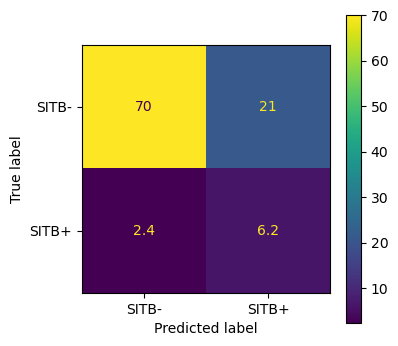

/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'shall', 'would'] not in stop_words.
  % sorted(inconsistent)
/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'shall', 'would'] not in stop_words.
  % sorted(inconsistent)
/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'shall', 'would'] not in stop_words.
  % s

In [43]:
%%time
text_features = 'content'

ts_i = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')



vectorizer = TfidfVectorizer(analyzer='word', binary=False,
                 decode_error='strict',
                 encoding='utf-8', input='content',
                 lowercase=True, max_df=0.8, max_features=None,
                 min_df=3, ngram_range=(1,2), norm='l2',
                 preprocessor=preprocess, smooth_idf=True,
                 stop_words=stopwords.words('english'), strip_accents='unicode',
                 sublinear_tf=True,
                 token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=custom_tokenizer, use_idf=True,
                 vocabulary=None)


model = LogisticRegression(class_weight="balanced", solver='liblinear')




# t_clf = Pipeline(
#       [
#           ("vectorizer",vectorizer),
#         ("balancer", SMOTE(random_state=123)),
#           ("lgbm", model)
#       ])


t_clf = imb_Pipeline([
     ('vectorizer', vectorizer),
     ('balancer', RandomUnderSampler(random_state=123)),
     ('model', model), # this is class_weight='balanced'
    ])

                      
# see all parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html
# https://datascience.stackexchange.com/questions/108233/recommendations-for-tuning-xgboost-hyperparams

# get cross validation split indexes
iterable_train_val_indexes = []
for train_i, val_i in kf.split(X_train_text):
    iterable_train_val_indexes.append((train_i,val_i))

text_grid_search = GridSearchCV(t_clf, param_grid, cv=iterable_train_val_indexes, scoring=["f1"],refit="f1", n_jobs=-1)
text_grid_search.fit(X_train_text,y_train)


print(text_grid_search.best_score_, text_grid_search.best_params_)

# need to add estimator to parameter names 

# retrain with best params and evaluate on test set
results = save_results_df(text_grid_search,X_train_text,y_train,X_test_text,y_test,
                          model_name='logreg_text',
                         output_dir=output_dir_i, ts = ts_i)

for k, v in results.get('logreg_text').items():
    print(k) 
    display(v)
    print()

In [39]:
print(text_grid_search.best_score_, text_grid_search.best_params_)

0.5709508936001911 {'model__C': 1, 'model__penalty': 'l2', 'vectorizer__max_features': None}


/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'shall', 'would'] not in stop_words.
  % sorted(inconsistent)
/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'shall', 'would'] not in stop_words.
  % sorted(inconsistent)
/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'shall', 'would'] not in stop_words.
  % s

# Text + Metadata model

In [ ]:

toy = False

if toy:
    print('WARNING, running toy version')
    param_grid = {
       'preprocessor__text__vectorizer__max_features': [2000, None],
        'model__penalty': ['l1', 'l2'],
    }
else:
    param_grid = {
        'preprocessor__text__vectorizer__max_features': [256, 512,2048, None],
        'model__C': [0.1, 0.3, 0.6, 1],
        'model__penalty': ['l1', 'l2'],
    }

In [249]:
%%time


ts_i = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')

numeric_features = ['contact_size','reputation','type']
text_features = 'type_tag_content'

# get cross validation split indexes
iterable_train_val_indexes = []
for train_i, val_i in kf.split(X_train_metadata):
    iterable_train_val_indexes.append((train_i,val_i))
    
# Define pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

text_transformer = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(analyzer='word', binary=False,
                 decode_error='strict',
                 encoding='utf-8', input='content',
                 lowercase=True, max_df=0.8, max_features=20000,
                 min_df=3, ngram_range=(1, 2), norm='l2',
                 preprocessor=preprocess, smooth_idf=True,
                 stop_words=stopwords.words('english'), strip_accents='unicode',
                 sublinear_tf=True,
                 token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=custom_tokenizer, use_idf=True,
                 vocabulary=None))])
    
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('text', text_transformer, text_features)])


model = LogisticRegression(class_weight="balanced", solver='liblinear')


mnt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])





meta_num_text_grid_search = GridSearchCV(mnt_clf, param_grid, cv=iterable_train_val_indexes, scoring=["f1"],refit="f1", n_jobs=-1)
meta_num_text_grid_search.fit(X_train_metadata,y_train)

# need to add estimator to parameter names 
best_params = {}
for k,v in meta_num_text_grid_search.best_params_.items():
    best_params['estimator__'+k] = v


# retrain with best params and evaluate on test set
results = save_results_df(meta_num_text_grid_search,best_params,X_train_metadata,y_train,X_test_metadata,y_test,
                          model_name='logreg_metadata',
                         output_dir=output_dir_i, ts = ts_i)

for k, v in results.get('logreg_metadata').items():
    print(k) 
    display(v)
    print()

KeyboardInterrupt: 